# Parameter Fitting for Mortals

This chapter is about parameter fitting, estimating the values of model parameters when they are not known in advance.
Parameters are constants used in models, such as kinetics contants for reactions.
Although there is often knowledge of likely ranges of parameter values, the appropriate value is often unknown
for a specific model.
Examples
of parameters are kinetics constants, Hill equation exponents, and initial concentrations of floating species.

## TOC
* [Packages and Constants](#parameter-fitting-packages-and-constants)
* [Motivating Exampe](#parameter-fitting-motivating-example)
* [Helper Functions](#parameter-fitting-helper-functions)
* [Fitting Basics](#parameter-fitting-fitting-basics)
* [Optimization Essentials](#parameter-fitting-optimization-essentials)
* [Fitting With SBstoat](#parameter-fitting-fitting-with-sbstoat)
* [Exploring the Linear Pathway Model](#parameter-fitting-exploring-the-linear-pathway-model)
* [Fitting Example: Gylcolytic Oscillations](#parameter-fitting-fitting-example-glycolytic-oscillations)
* [Appendix 1: Synthetic Data For Linear Pathway](#parameter-appendix-1-synthetic-data-for-linear-pathway)
* [Appendix 2: Synthetic Data For Glycolytic Oscillations](#parameter-appendix-1-synthetic-data-for-glycolytic-oscillations)

## Packages and Constants <a class="anchor" id="parameter-fitting-packages-and-constants"></a>

In [1]:
# Python packages used in this chapter
import matplotlib.pyplot as plt
import numpy as np
import tellurium as te
from SBstoat.namedTimeseries import NamedTimeseries, TIME
from SBstoat.modelFitter import ModelFitter
import SBstoat

In [2]:
# Constants used in this chapter
LINEAR_PATHWAY_RR = te.loada("../common/models/linear_pathway.ant")
LINEAR_PATHWAY_MODEL = LINEAR_PATHWAY_RR.getAntimony()
LINEAR_PATHWAY_DATA = "../common/models/linear_pathway_data.csv"
# Wolf model
WOLF_RR = te.loada("../common/models/wolf.ant")
WOLF_MODEL = WOLF_RR.getAntimony()
ENDTIME = 5
NUMPOINT = 100*ENDTIME
WOLF_DATA = "../common/models/wolf_data.csv"

## Motivating Example <a class="anchor" id="parameter-fitting-motivating-example"></a>

To make these ideas concrete, consider a linear pathway consisting of three species ``S1``, ``S2``, and ``S3``. That is, ``S1`` $\rightarrow$ ``S2`` $\rightarrow$ ``S3``.
The Antimony model is shown below.

In [3]:
print(LINEAR_PATHWAY_MODEL)

// Created by libAntimony v2.12.0
// Compartments and Species:
species S1, S2, S3, S4, S5;

// Reactions:
R1: S1 -> S2; k1*S1;
R2: S2 -> S3; k2*S2;
R3: S3 -> S4; k3*S3;
R4: S4 -> S5; k4*S4;

// Species initializations:
S1 = 10;
S2 = ;
S3 = ;
S4 = ;
S5 = ;

// Variable initializations:
k1 = 0;
k2 = 0;
k3 = 0;
k4 = 0;

// Other declarations:
const k1, k2, k3, k4;



Note that the values of the parameters are 0! This is not because their true value is 0.
Rather, it's because we don't know the value of these parameters.

It is very common to have parameters with unknown values in kinetics models. Typically, we know the range
of the parameter values, but not a suitable value itself.

So, how do we run a model with known values for *all* of its parameters? The answer is that we estimate or **fit paramter values** based on observed data.

For this example, the observational data are in the file specified in ``LINEAR_PATHWAY_DATA``.

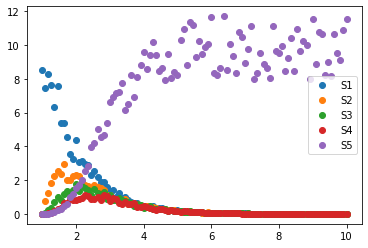

In [4]:
data = NamedTimeseries(csvPath=LINEAR_PATHWAY_DATA)
fig, ax = plt.subplots(1)
for col in data.colnames:
    ax.scatter(data[TIME], data[col])
_ = plt.legend(data.colnames)

## Helper Functions <a class="anchor" id="parameter-fitting-helper-functions"></a>

In [5]:
def plotTS(ts, title=""):
    """
    Plots columns in a timeseries.
    
    Parameters
    ----------
    ts: NamedTimeseries
    """
    p = plt.plot(ts[TIME], ts[ts.colnames])
    _ = plt.legend(p, ts.colnames, bbox_to_anchor=(1.05, 1), loc='upper left')
    _ = plt.title(title)

In [6]:
def makeSyntheticTS(trueTS, proportion):
    """
    Constructs synthetic data in proportion to values of true data.
    
    Parameters
    ----------
    trueTS: NamedTimeseries of true data
    proportion: float indicating the proportional of value to change
    
    Returns
    -------
    NamedTimeseries
    """
    synTS = trueTS.copy()
    for col in synTS.colnames:
        epsilons = np.random.uniform(-1, 1, len(synTS))
        synTS[col] += proportion*synTS[col]*epsilons
    return synTS

The following sections provide details of parameter fitting using the ``PATHWAY_MODEL``.

## Fitting Basics <a class="anchor" id="parameter-fitting-fitting-basics"></a>

Some key concepts are:
- A **parameter** is a constant whose value is unknown.
- **Observed data** are data that are used for fitting parameter values.
- **Fitted data** are data produced by a simulation for an assignment of values to parameters.
- **Residuals** are the difference between observed data and simulated data.

The basic algorithm for fitting is described below.
The algorithm estimates ``parameters``, the vector of values of unknown parameters.
The inputs to the algoritm are:
- ``model`` - the simulation model
- ``parameters`` parameters to estimate with their initial values
- ``observedData`` observed data used for fitting

1. **Initialization**
   1. ``fittedData = simulate(model, parameters)``
   1. ``residuals = observedData - fittedData``
1. **Loop**
   1. ``parameters`` = adjust ``parameters`` based on ``residuals``
   1. ``fittedData = simulation(parameters)``
   1. ``residuals = observedData - fittedData``
   1. if ``residuals`` are small
       1. ``return parameters``

The algorithm is fairly straight forward, with one exception.
Step A - "adjust ``parameters`` based on ``residuals``" How are these adjustments made?

The adjustments are made based on an optimization that chooses parameter values that
minimize the residuals.
We give a brief discussion of optimization in the next section.

## Optimization Essentials <a class="anchor" id="parameter-fitting-optimization-essentials"></a>

Given a function $f(x_1, \cdots, x_n)$, an optimizer finds $(x_1^{\star}, \cdots, x_n^{\star})$
that results in the smallest value of $f(x_1, \cdots, x_n)$.

Sometimes, this search is easy. Consider the curve below.

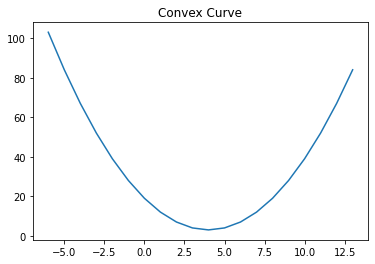

In [7]:
xv = np.array(range(20))
xv = xv - 6
_ = plt.plot(xv, 3 + (xv - 4)**2 )
_ = plt.title("Convex Curve")

We can readily see that the minimum value of this function occurs at $x^{\star} = 4$.
This is an example of a convex curve. A convex curve has the very nice property
that its local minimum is also the global minimum.
That is, there are no small valleys where the optimizer might get "stuck".
For this reason, it's easy to find $x^{\star}$ using gradient decent or
Newton's method.

Unfortunately, convex curves are rare in practice. Much more common is something like the following.

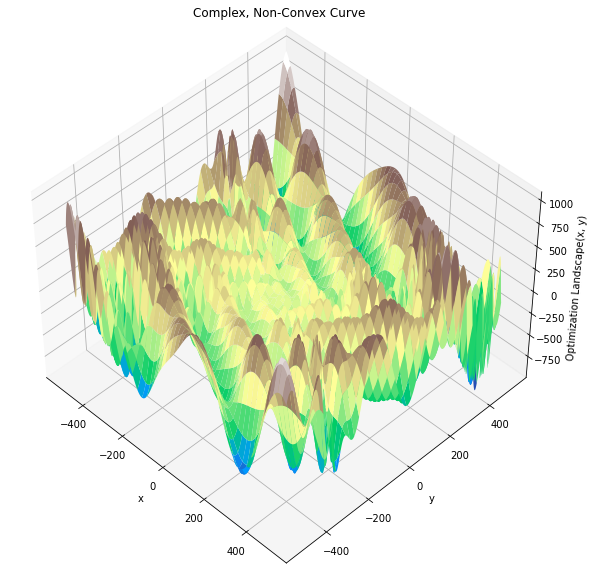

In [8]:
from mpl_toolkits.mplot3d import Axes3D

def eggholder(x):
    return (-(x[1] + 47) * np.sin(np.sqrt(abs(x[0]/2 + (x[1]  + 47))))
          -x[0] * np.sin(np.sqrt(abs(x[0] - (x[1]  + 47)))))

x = np.arange(-512, 513)
y = np.arange(-512, 513)
xgrid, ygrid = np.meshgrid(x, y)
xy = np.stack([xgrid, ygrid])

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(45, -45)
ax.plot_surface(xgrid, ygrid, eggholder(xy), cmap='terrain')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Optimization Landscape(x, y)')
ax.set_title("Complex, Non-Convex Curve")
plt.show()

For curves such as these, hueristic methods are needed such as differential evolution, simulated annealing, and random stochastic
gradient descent.

## Fitting With SBstoat <a class="anchor" id="parameter-fitting-fitting-with-sbstoat"></a>

### Running SBstoat

``SBstoat`` is a python package intended to simplify the programmatic aspects of fitting. The package provides handles the programming details
of the interactions between the optimization codes (``lmfit``) and ``tellurium`` simulations.

The required inputs to ``SBstoat`` are:
- the model for which parameter values are being estimated;
- observational data; and
- specification of the parameters, their value ranges, and initial values.

For the linear pathway model, we ``LINEAR_PATHWAY_MODEL`` and ``LINEAR_PATHWAY_DATA`` for the model and data, respectively.
The description of the paarameters is done using a python dictionary, as shown below.

In [9]:
# Name, minimal value, initial value, and maximum value of each parameter
LINEAR_PATHWAY_PARAMETER_DCT = {
    "k1": (1, 50, 100),
    "k2": (1, 50, 100),
    "k3": (1, 50, 100),
    "k4": (1, 50, 100),
    }

The python class ``ModelFitter`` does fitting for ``SBstoat``. Details of using this can be found below.

In [10]:
?ModelFitter

Init signature: ModelFitter(*args, **kwargs)
Docstring:      Cross validation for ModelFitter
Init docstring:
Constructs estimates of parameter values.

Parameters
----------
endTime: float
    end time for the simulation
modelSpecification: ExtendedRoadRunner/str
    roadrunner model or antimony model
observedData: NamedTimeseries/str
    str: path to CSV file
parametersToFit: list-str/SBstoat.Parameter/None
    parameters in the model that you want to fit
    if None, no parameters are fit
selectedColumns: list-str
    species names you wish use to fit the model
    default: all columns in observedData
parameterLowerBound: float
    lower bound for the fitting parameters
parameterUpperBound: float
    upper bound for the fitting parameters
logger: Logger
fitterMethods: str/list-str/list-OptimizerMethod
    method used for minimization in fitModel
numFitRepeat: int
    number of times fitting is repeated for a method
bootstrapMethods: str/list-str/list-OptimizerMethod
    method used 

In [11]:
fitter = ModelFitter(LINEAR_PATHWAY_MODEL, LINEAR_PATHWAY_DATA, parameterDct=LINEAR_PATHWAY_PARAMETER_DCT)
fitter.fitModel()

TypeError: __init__() got an unexpected keyword argument 'parameterDct'

``SBstoat`` provides a textual report of the results of the fit.

In [ ]:
print(fitter.reportFit())

The report is in three sections.

The first section contains measures of the fit quality. The most commonly used measures are chi-square and reduced chai-square.
We want both of these to be "small", although small is relative.
These measures are most useful when comparing different fit results.

The "Variables" section gives parameter estimates. We se that the estimates obtained are fairly close to
the true values in the original models.

The final section provides information about the relationships between parameter estimates. This can be useful
in models where the structure of the model makes it difficult to separate one parameter from another.
In these cases, there will be a large correlation between parameter (absolute) parameter values.

``SBstoat`` provides many plots to aid in understanding the fitting results.
You can see these by typing in a Jupyter code cell ``fitter.pl`` and then pressing the tab key.
Arguably the most useful is ``plotFitAll``, which, for each floating species (column in observed data), plots the fitted and observed values.
This is shown below.

In [ ]:
fitter.plotFitAll(figsize=(20, 5), numCol=5, color=["red", "blue"], titlePosition=(0.5, 1.05))

These fits seem to be quite consistent with the observed data, with the possible exception of ``S5``.
In the latter case, there is considerable variability that likely makes a good fit more difficult.

In [ ]:
# See the options for plotFitAll
?fitter.plotFitAll

If you are interested in a more complete analysis of the residuals, use ``plotResidualsAll``.

In [ ]:
fitter.plotResidualsAll(figsize=(20, 10))

## Exploring the Linear Pathway Model <a class="anchor" id="parameter-fitting-exploring-the-linear-pathway-model"></a>

Although ``SBstoat`` eliminates the burden of programming details, fitting is often complex.
This is because of the complexity of the fitting surface, as illustrated earlier in this chaper.
This section illustrates how to use ``SBstoat`` to explore complex fitting surfaces.

``SBstoat`` allows you to explore fitting along three dimensions.
1. **Fitting surface**. The fitting surface changes based on the following:
  a. the selection of float species (columns in the observed data) that we attempt to fit;
  b. the time span we fit over
1. **Search stategy**. This depends on our choice of optimization algorithm. Beyond this, we may choose to use several optimization
algorithms in sequence. Also, some optimization algorithms are stochastic, and so the search strategy may also choose to run
the same algorithm multiple times.
1. **Search start & scope**. This refers to the initial values of parameter values and the range of parameter values that are explored.


In the following explorations of the above dimensions of parameter fitting, we use the above workflow that consists of:
1. Select a subset of the observed data based on a specified time span (in this case, just ending time)
1. Construct a fitter for the linear pathway, observed data, columns to consider in fitting, the fitting methods, and parameter ranges/initial values.
1. Fit the model.
1. Print the fitting report.
1. Plot observed and fitted values.

This workflow is encapsulated in the the function ``doFit``.
The arguments of the function have default that reproduce the
results in the previous section.

In [ ]:
def doFit(selectedColumns=None, endTime=10, fitterMethods=["differential_evolution", "leastsq"], parameterDct=LINEAR_PATHWAY_PARAMETER_DCT):
    model = te.loada(LINEAR_PATHWAY_MODEL)
    observedTS = NamedTimeseries(LINEAR_PATHWAY_DATA)
    # Find the last index to use
    lastIdx = len([t for t in observedTS[TIME] if t <= endTime])
    observedTS = observedTS[:lastIdx]
    # Construct the fitter and do the fit
    fitter = ModelFitter(model, observedTS, selectedColumns=selectedColumns, fitterMethods=fitterMethods, parameterDct=parameterDct)
    fitter.fitModel()
    print(fitter.reportFit())
    fitter.plotFitAll(figsize=(20, 5), numCol=5, color=["red", "blue"],  titlePosition=(0.5, 1.05))

In [ ]:
doFit()

### Fitting Surface

We begin by exploring the effect of the fitting surface. Suppose that we only consider ``S5`` and so the fitting surface is residuals
from fitting ``S5``.

In [ ]:
doFit(selectedColumns=["S5"])

We see that the fitted line does not match well the dynamics in the observed data. Another observation is that the chi-square increased
by a factor of 10.
In general, we recommend that all floating species be used.

Another consideration is to focus on a subset of the dynamics. Below, we only consider through 6 seconds.

In [ ]:
doFit(endTime=6)

This improved the quality of the fit. We see this visually in the above plots and also in the significant reduction in chi-square. A lot of this improvement
is a result of not inluding regions of high variability in observed values for ``S5``.

### Search Strategy

The main consideration here is the choice of optimization algorithms.
Any valid ``method`` for ``lmfit`` can be used, and multiple methods can be used in combination. We illustrate this below.

In [ ]:
# Fit with Levenberg-Marquardt 
doFit(fitterMethods=["leastsq"])

In [ ]:
# Fit with differential evolution
doFit(fitterMethods=["differential_evolution"])

In [ ]:
# Fit with differential evolution and then Levenberg-Marquardt 
doFit(fitterMethods=["differential_evolution", "leastsq"])

For this model, we see that Levenberg-Marquardt works better than differential evolution, and doing the two in combination offers no benefit.

### Search Start & Scope

Where we start the search and how far we search depends on the ranges of parameter values and the specification of initial values.
This is specified by the ``parameterDct`` argument to ``ModelFitter``. This argument defaults to ``LINEAR_PATHWAY_PARAMETER_DCT``.

In [ ]:
# Dictionary values are: lower end of parameter range, initial parameter value, upper end of parameter range
LINEAR_PATHWAY_PARAMETER_DCT

If we create a bad parameter range, then we get very poor fits. Below, we start the search with a negative value for each parameter.
Note that the observed values appear to be constant because of the large scale of the fitted values.

In [ ]:
parameterDct = {
 'k1': (-11, -1, 100),
 'k2': (-11, -1, 100),
 'k3': (-11, -1, 100),
 'k4': (-11, -1, 100)}
doFit(parameterDct=parameterDct)

## Fitting Example: Glycolytic Oscillations <a class="anchor" id="parameter-fitting-fitting-example-glycolytic-oscillations"></a>

This section illustrates parameter fitting using the Wolf model for glycolytic oscillations. We consider just two the several parameters: ``J1_n`` (a Hill constant) and ``J9_k`` (a kinetics rate constant).

Our starting point is the following:
1. **Fitting surface**. We consider all columns and all time.
1. **Search stategy**. We use differentiation evolution followed by Levenberg-Marquardt (leastsq)
1. **Search start & scope**. For both, we use the range ``[1, 100]`` with an initial value of 1.

Below is the definition of the parameter values (with the true values in the comment).

In [ ]:
# Parameter ranges and initial value
WOLF_PARAMETER_DCT = {
      "J1_n": (1, 1, 100),  # True value is 4
      "J9_k": (1, 1, 100),   # True value is 28
    }

As before, we encapsulate our workflow in a ``doFit`` function. There is one subtly included here - the argument to ``fitModel``
has ``max_nfev`` set to ``None``. This value is passed to ``lmfit``, and instruct those codes to use an unlimited number
of iterations to converge.
This is useful in more complex models, but it can come at the cost of increased computation times.

In [ ]:
def doFit(endTime=5, fitterMethods=["leastsq"], parameterDct=WOLF_PARAMETER_DCT):
    model = te.loada(WOLF_MODEL)
    observedTS = NamedTimeseries(WOLF_DATA)
    # Find the last index to use
    lastIdx = len([t for t in observedTS[TIME] if t <= endTime])
    observedTS = observedTS[:lastIdx]
    # Construct the fitter and do the fit
    fitter = ModelFitter(model, observedTS, fitterMethods=fitterMethods, parameterDct=parameterDct)
    fitter.fitModel(max_nfev=None)
    print(fitter.reportFit())
    fitter.plotFitAll(figsize=(24,16), numCol=2, color=["red", "blue"])

We begin by assessing the fits and their quality.

In [ ]:
doFit()

Since this is our first attempt at fitting this model, it's difficult to make a judgement about the relative size of the chi-square values.
However, we can make a judgement about the fit quality from the above plots.
- There is a limited ability to capture the initial transient that occurs in the first 1 sec.
- There is no ability to capture the glycolytic oscillations.

We begin by addressing the the fitting surface by focusing on a more narrow time range, to balance better the initial transient and the oscillations.

In [ ]:
doFit(endTime=2)

The net effect is to get a "close up" of the initial part of the simulation, not to change
the values of the parameter estimates.

Next, we try a different search algorith, differential evolution.

In [ ]:
doFit(endTime=2, fitterMethods=["differential_evolution"])

This didn't seem to help much with capturing the oscillations. So, now we consider a different initial value for the parameters.

In [ ]:
# Parameter ranges and initial value
WOLF_PARAMETER_START_HIGH_DCT = {
      "J1_n": (1, 100, 100),  # True value is 4
      "J9_k": (1, 100, 100),   # True value is 28
    }
doFit(endTime=2, fitterMethods=["differential_evolution"], parameterDct=WOLF_PARAMETER_START_HIGH_DCT)

Visually, this is a much better fit, catching both the initial transient and the oscillations.
Also, we see a dramatic reduction in the chi-square values.

Now, we try fitting on the entire time range.

In [ ]:
doFit(fitterMethods=["differential_evolution"], parameterDct=WOLF_PARAMETER_START_HIGH_DCT)

This works quite well!

At this point, we revisit whether it's necessary to use differential_evolution instead of leastsq since the former is much more computationally
intensive than the latter.

In [ ]:
doFit(parameterDct=WOLF_PARAMETER_START_HIGH_DCT)

Clearly, the choice of the differential evolution optimization algorithm was critical to getting a good fit.

We conclude that the key to fitting these data are the following:
1. using the differential_evoluation optimization algorithm
1. start at the high end of the parameter ranges instead of the low end.

## Appendix 1 - Synthetic Data for Linear Pathway <a class="anchor" id="parameter-appendix-1-synthetic-data-for-linear-pathway"></a>
This appendix describes how data was generated to create synthetic observations for the linear pathway example.

The first step is to generate data for the "ground truth" model.

In [ ]:
# Constants used in this Appendix
LINEAR_PATHWAY_PARAMETER_DCT = {
    "k1": 1.0,
    "k2": 2.0,
    "k3": 3.0,
    "k4": 4.0,
}
LINEAR_PATHWAY_PROPORTION = 0.2

In [ ]:
rr = te.loada(LINEAR_PATHWAY_MODEL)
for parameter in LINEAR_PATHWAY_PARAMETER_DCT.keys():
    rr[parameter] = LINEAR_PATHWAY_PARAMETER_DCT[parameter]
trueTS = NamedTimeseries(namedArray=rr.simulate(1, 10, 100))
plotTS(trueTS, title="True Model for Linear Pathway")

Next, we convert the output data, a numpy named array, into a ``NamedTimeseries``, a data structure that is well suited for
time series manipulations.

In [ ]:
syntheticTS = makeSyntheticTS(trueTS, LINEAR_PATHWAY_PROPORTION)

Now, we add some random noise. For this example, we add normally distributed random variables with a mean of 0
and a standard deviation of 0.2.

In [ ]:
plotTS(syntheticTS, title="Synthetic Data for Linear Pathway")

Last, we write the result to a file.

In [ ]:
#syntheticTS.to_csv(LINEAR_PATHWAY_DATA)

## Appendix 2 - Synthetic Data for Glycolytic Oscilations <a class="anchor" id="parameter-appendix-1-synthetic-data-for-glycolytic-oscillations"></a>

In [ ]:
# Constants used in this Appendix
WOLF_PROPORTION = 0.3

This appendix describes how data was generated to create synthetic observations for the Wolf
glycolytic oscillations model.

We see that in this mode there is a large variation in the scale of the values of the time series.

In [ ]:
rr = te.loada(WOLF_MODEL)
trueTS = NamedTimeseries(namedArray=rr.simulate(0, ENDTIME, NUMPOINT))
plotTS(trueTS, "True Wolf Model")

So, constructing meaningful synthetic observed data requires some thought.

Our approach is to use a *proportional error model*.
That is, the variability we introduced, which is referred to as *error* in statistics, depends on the true value.
Let $x$ be the true value of the variable, $p$ be the proportion for which we introduce "error",
and $\epsilon$ be a random number chosen uniformly from $[-1, 1]$.
Then, the synthetic observed values is $x (1 +  p \epsilon)$.

In [ ]:
syntheticTS = makeSyntheticTS(trueTS, WOLF_PROPORTION)
plotTS(syntheticTS, title = "Synthetic Data for Wolf Model")

In [ ]:
#syntheticTS.to_csv(WOLF_DATA)